In [ ]:
import os
import copy
import pickle
import sympy
import functools
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from error_injection import MissingValueError, SamplingError, Injector
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mutual_info_score, auc, roc_curve, roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree
from scipy.optimize import minimize as scipy_min
from scipy.spatial import ConvexHull
from scipy.optimize import minimize, Bounds, linprog
from sympy import Symbol as sb
from sympy import lambdify
from tqdm.notebook import trange,tqdm
from IPython.display import display,clear_output
from random import choice
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

class style():
    RED = '\033[31m'
    GREEN = '\033[32m'
    BLUE = '\033[34m'
    RESET = '\033[0m'

np.random.seed(1)

# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_mpg():
    # fetch dataset
    auto_mpg = pd.read_csv('auto-mpg.csv').drop('car name', axis=1).replace('?', np.nan)
    
    features = ['cylinders', 'displacement', 'horsepower', 'weight',
                'acceleration', 'model year', 'origin']
    X = auto_mpg[features].astype(float)
    y = auto_mpg['mpg']
    
    # with this random seed, no null value is included in the test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = copy.deepcopy(X_train).reset_index(drop=True)
    X_test = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return X_train, X_test, y_train, y_test


# first impute the data and make it hypothetically clean
def load_mpg_cleaned():
    # fetch dataset
    auto_mpg = pd.read_csv('auto-mpg.csv').drop('car name', axis=1).replace('?', np.nan)
    
    features = ['cylinders', 'displacement', 'horsepower', 'weight',
                'acceleration', 'model year', 'origin']
    X = auto_mpg[features].astype(float)
    y = auto_mpg['mpg']
    
    # assumed gt imputation
    imputer = KNNImputer(n_neighbors=10)
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = copy.deepcopy(X_train).reset_index(drop=True)
    X_test = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = load_mpg_cleaned()

In [5]:
y_train

0      23.0
1      14.0
2      37.0
3      21.0
4      32.3
       ... 
313    27.0
314    25.1
315    15.0
316    26.0
317    18.0
Name: mpg, Length: 318, dtype: float64

## Unique Functions:

In [6]:
#Useful functions
symbol_id = -1
def create_symbol(suffix=''):
    global symbol_id
    symbol_id += 1
    name = f'e{symbol_id}_{suffix}' if suffix else f'e{symbol_id}'
    return sympy.Symbol(name=name)


scaler_symbols = set([sb(f'k{i}') for i in range(X_train.shape[1]+1)])
linearization_dict = dict()
reverse_linearization_dict = dict()

def inject_sensitive_ranges(X, y, uncertain_attr, uncertain_num, boundary_indices, uncertain_radius_pct=None, 
                  uncertain_radius=None, seed=42):
    global symbol_id
    symbol_id = -1
    
    X_extended = np.append(np.ones((len(X), 1)), X, axis=1)
    ss = StandardScaler()
    X_extended[:, 1:] = ss.fit_transform(X_extended[:, 1:])
    X_extended_symb = sympy.Matrix(X_extended)
    
    if not(uncertain_attr=='y'):
        uncertain_attr_idx = X.columns.to_list().index(uncertain_attr) + 1
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(np.max(X_extended[:, uncertain_attr_idx])-\
                                                     np.min(X_extended[:, uncertain_attr_idx]))
    else:
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(y_train.max()-y_train.min())[0]
    
    np.random.seed(seed)
    uncertain_indices = boundary_indices[:uncertain_num]
    y_symb = sympy.Matrix(y)
    symbols_in_data = set()
    #print(uncertain_indices)
    for uncertain_idx in uncertain_indices:
        new_symb = create_symbol()
        symbols_in_data.add(new_symb)
        if uncertain_attr=='y':
            y_symb[uncertain_idx] = y_symb[uncertain_idx] + uncertain_radius*new_symb
        else:
            X_extended_symb[uncertain_idx, uncertain_attr_idx] = X_extended_symb[uncertain_idx, uncertain_attr_idx] + uncertain_radius*new_symb
    return X_extended_symb, y_symb, symbols_in_data, ss

# if interval=True, use interval arithmetic, otherwise use zonotopes
def compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, robustness_radius,
                                         uncertain_num, boundary_indices, uncertain_radius=None, 
                                         lr=0.1, seed=42, interval=True):
    X, y, symbols_in_data, ss = inject_sensitive_ranges(X=X_train, y=y_train, uncertain_attr='y', 
                                              uncertain_num=uncertain_num, boundary_indices=boundary_indices, 
                                              uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=None, seed=seed)
    
    assert len(X.free_symbols)==0
    # closed-form
    param = (X.T*X).inv()*X.T*y
    
    if interval:
        # make param intervals
        for d in range(len(param)):
            expr = param[d]
            if not(expr.free_symbols):
                continue
            else:
                constant_part = 0
                interval_radius = 0
                for arg in expr.args:
                    if arg.free_symbols:
                        interval_radius += abs(arg.args[0])
                    else:
                        assert constant_part == 0
                        constant_part = arg
                param[d] = constant_part + create_symbol()*interval_radius
    
    test_preds = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))*param
    robustness_ls = []
    for pred in test_preds:
        pred_range_radius = 0
        for arg in pred.args:
            if arg.free_symbols:
                pred_range_radius += abs(arg.args[0])
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
    
#     print(param)
    return np.mean(robustness_ls)

In [7]:
def identify_extreme_quantiles(y, lower_quantile=0.1, upper_quantile=0.9):
    """
    Identifies indices of `y` values in the extreme quantiles.
    
    """
    lower_threshold = np.quantile(y, lower_quantile)
    upper_threshold = np.quantile(y, upper_quantile)
    
    # Indices where `y` is in the extreme lower or upper quantiles
    extreme_indices = np.where((y <= lower_threshold) | (y >= upper_threshold))[0]
    return extreme_indices

extreme_indices = identify_extreme_quantiles(y_train)

In [8]:
def compute_prediction_variance(X, y, num_models=10):
    """
    Estimates prediction variance for each `y` value using an ensemble of models.

    """
    predictions = []
    
    for i in range(num_models):
        X_resampled, y_resampled = resample(X, y, random_state=i)
        model = LinearRegression().fit(X_resampled, y_resampled)
        predictions.append(model.predict(X))
    
    # Stack predictions and compute standard deviation for each point
    predictions = np.vstack(predictions)
    prediction_std = np.std(predictions, axis=0)
    return prediction_std


X = X_train 
y = y_train
prediction_variance = compute_prediction_variance(X, y)

# Find indices of high-variance predictions (e.g., top 10%)
high_variance_indices = np.argsort(prediction_variance)[-int(0.1 * len(y)):]

In [9]:
combined_indices = np.unique(np.concatenate([extreme_indices, high_variance_indices]))

In [10]:
combined_indices

array([  1,   2,   5,   9,  12,  13,  21,  23,  24,  25,  28,  29,  31,
        36,  39,  40,  43,  45,  46,  52,  53,  54,  55,  57,  58,  62,
        66,  69,  71,  75,  76,  84,  85,  88,  90,  91,  95, 100, 103,
       108, 111, 113, 116, 118, 119, 121, 122, 124, 131, 138, 144, 147,
       149, 153, 158, 159, 163, 167, 169, 175, 185, 190, 192, 193, 198,
       199, 204, 206, 210, 213, 222, 223, 236, 237, 239, 240, 241, 242,
       249, 258, 262, 270, 272, 277, 284, 291, 293, 296, 297, 307, 310])

In [11]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=combined_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=combined_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


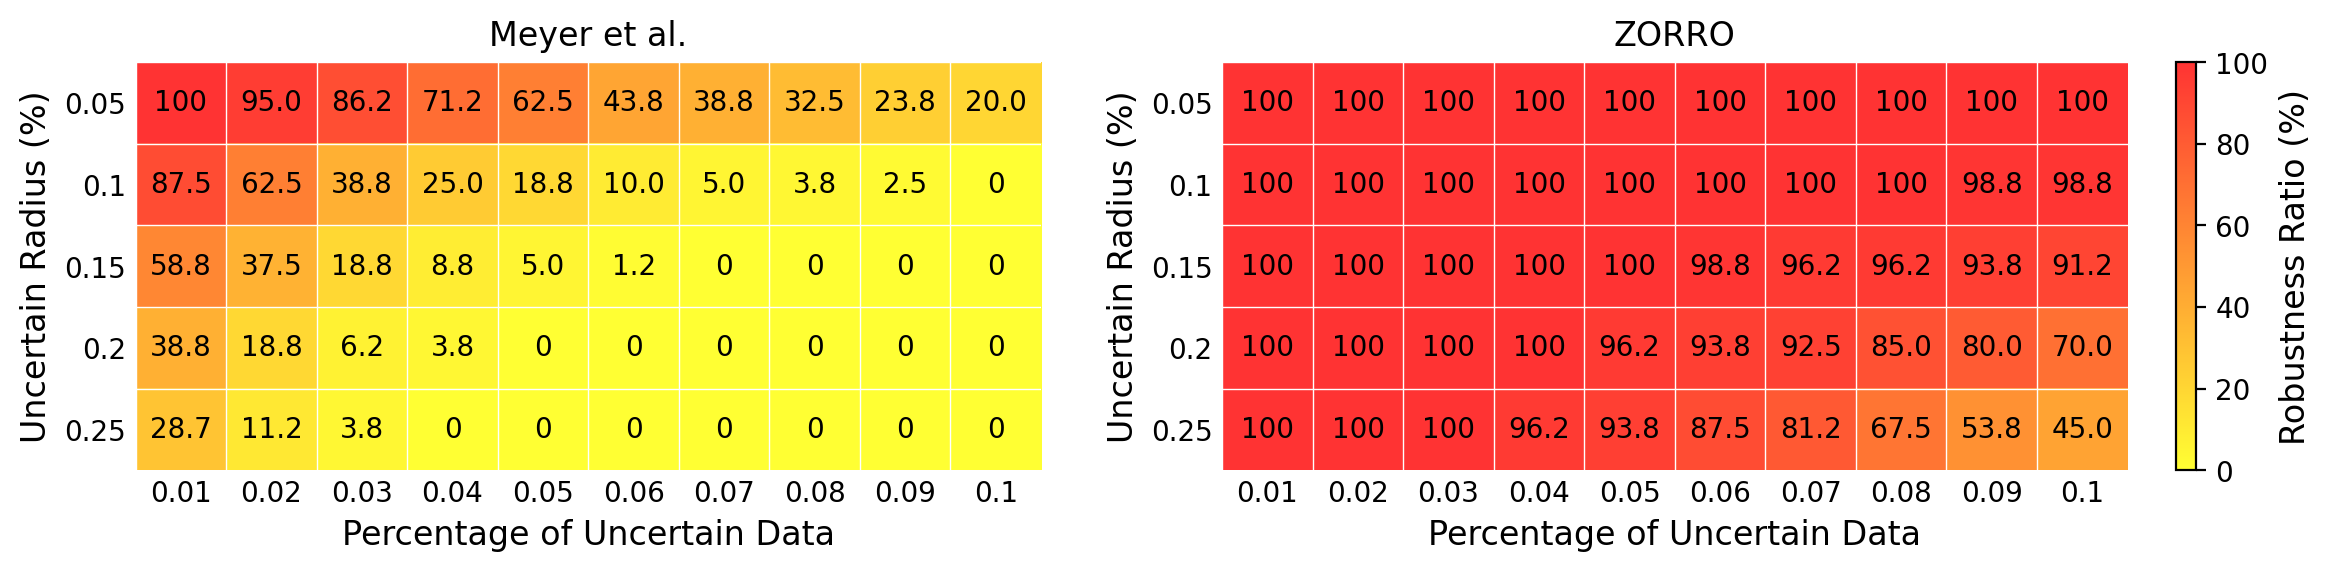

In [14]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('mpg-randomForest-sensitive-heatmap.pdf', bbox_inches='tight')

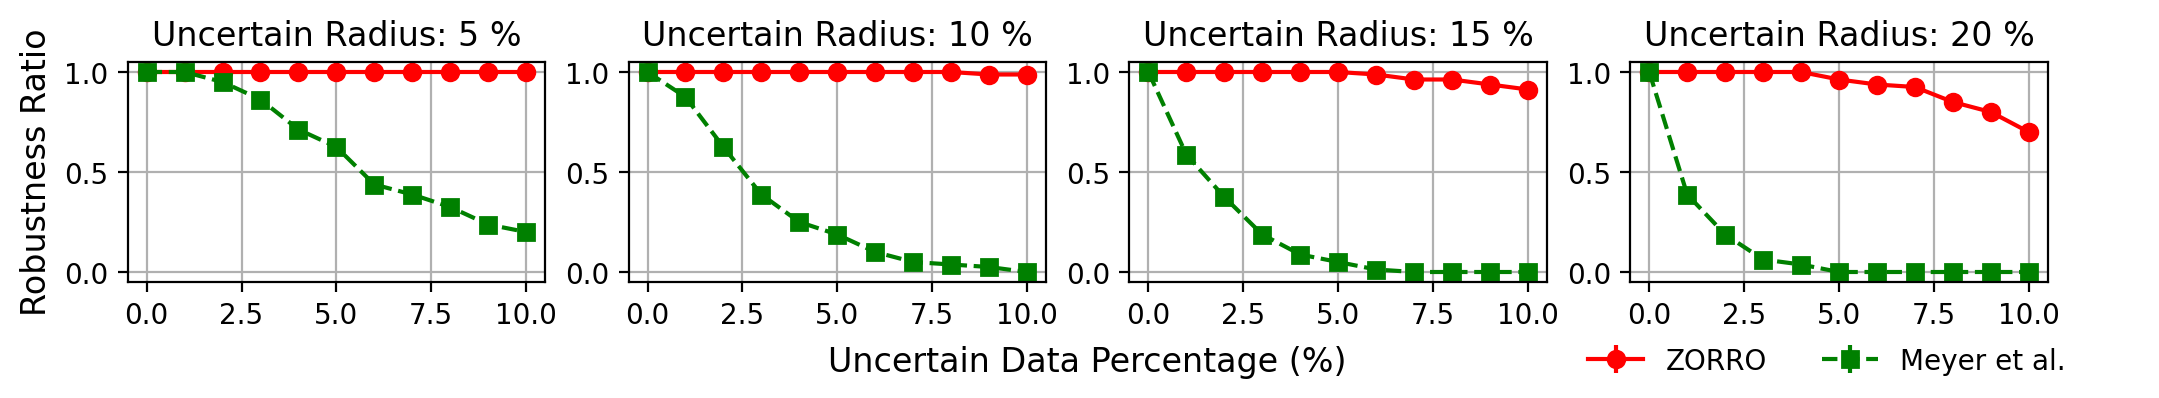

In [15]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-randomForest-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [16]:
def leave_one_out(X_train, y_train, X_test, y_test, model, metric):
    predictions = model.fit(X_train, y_train).predict(X_test)
    initial_metric = metric(y_test.to_numpy(), predictions)
    influence_results = []
   
    for i in range(len(X_train)):
        X_train_new = np.delete(X_train, i, axis=0)
        y_train_new = np.delete(y_train, i, axis=0)
       
        model_clone = model.__class__(**model.get_params())
        new_preds = model_clone.fit(X_train_new, y_train_new).predict(X_test)
        new_metric = metric(y_test.to_numpy(), new_preds)
       
        metric_diff = new_metric - initial_metric
        influence_results.append((i, metric_diff))
       
       
   
    influence_results = sorted(influence_results,key=lambda x: x[1], reverse=True)
    #print(influence_results)
    return [i[0] for i in influence_results]

def mae(y_true, y_pred):
    return sum(abs(y_true - y_pred))/len(y_true)

def mse(y_true, y_pred):
    return sum((y_true - y_pred)**2)/len(y_true)

def r_squared(y_true, y_pred):
    y_bar = np.mean(y_true)
    return 1 -(sum((y_true - y_pred)**2)/sum((y_true-y_bar)**2))

def rmse(y_true, y_pred):
    return np.sqrt(sum((y_true - y_pred)**2)/len(y_true))

In [17]:
#Using mae, randomforest:
rf = RandomForestRegressor()
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, rf, mae)
boundary_indices 

[260,
 245,
 238,
 256,
 18,
 148,
 37,
 50,
 206,
 242,
 275,
 53,
 237,
 280,
 176,
 92,
 235,
 2,
 46,
 89,
 217,
 250,
 70,
 104,
 293,
 149,
 84,
 113,
 279,
 28,
 131,
 198,
 79,
 19,
 183,
 51,
 282,
 155,
 158,
 209,
 288,
 130,
 6,
 12,
 207,
 312,
 7,
 248,
 42,
 55,
 72,
 313,
 202,
 179,
 99,
 205,
 128,
 278,
 151,
 197,
 138,
 203,
 39,
 69,
 274,
 196,
 286,
 220,
 156,
 201,
 214,
 94,
 200,
 266,
 105,
 261,
 91,
 174,
 270,
 65,
 96,
 285,
 112,
 244,
 11,
 13,
 232,
 317,
 115,
 67,
 154,
 204,
 287,
 172,
 132,
 190,
 213,
 15,
 126,
 297,
 164,
 194,
 265,
 108,
 102,
 90,
 210,
 315,
 170,
 38,
 16,
 121,
 316,
 66,
 307,
 41,
 168,
 302,
 247,
 175,
 3,
 153,
 281,
 33,
 289,
 292,
 118,
 74,
 180,
 162,
 252,
 56,
 107,
 219,
 272,
 97,
 222,
 298,
 100,
 78,
 185,
 227,
 241,
 221,
 230,
 47,
 49,
 182,
 257,
 249,
 45,
 59,
 139,
 147,
 52,
 98,
 276,
 177,
 111,
 243,
 166,
 304,
 269,
 116,
 246,
 133,
 239,
 167,
 25,
 228,
 20,
 9,
 169,
 208,
 32,
 71,
 1

In [ ]:
###WOKRING ON ITTTTTTT 
array_indexes = np.zeros(len(X_train))

perc = int(0.1 * len(X_train))

for i in range(perc):
    index = boundary_indices[i]
    array_indexes[index] = 1


mod = DecisionTreeClassifier().fit(X_train, array_indexes)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, _tree

# Fit the DecisionTreeClassifier
#mod = DecisionTreeClassifier().fit(X_train, array_indexes)

# Define function to find positive paths
def get_positive_paths(tree, feature_names, node=0, conditions=None):
    if conditions is None:
        conditions = {}
    
    left_child = tree.children_left[node]
    right_child = tree.children_right[node]
    threshold = tree.threshold[node]
    feature = tree.feature[node]
    
    # Check if it's a leaf node
    if left_child == _tree.TREE_LEAF and right_child == _tree.TREE_LEAF:
        # Check if it's a positive leaf node
        if tree.value[node][0, 1] > tree.value[node][0, 0]:  # More positive than negative
            print("Important Value Threshold Scenario:")
            # Print each feature's range in the conditions
            for feat, bounds in conditions.items():
                lower_bound = bounds.get('lower', '-∞')
                upper_bound = bounds.get('upper', '∞')
                print(f" - {feat}: {lower_bound} < {feat} <= {upper_bound}")
            print()
        return
    
    # Update bounds for the current feature in conditions
    feature_name = feature_names[feature]
    if left_child != _tree.TREE_LEAF:
        # Set an upper bound for the feature
        new_conditions = {k: v.copy() for k, v in conditions.items()}
        new_conditions.setdefault(feature_name, {}).update({'upper': threshold})
        get_positive_paths(tree, feature_names, left_child, new_conditions)
    
    if right_child != _tree.TREE_LEAF:
        # Set a lower bound for the feature
        new_conditions = {k: v.copy() for k, v in conditions.items()}
        new_conditions.setdefault(feature_name, {}).update({'lower': threshold})
        get_positive_paths(tree, feature_names, right_child, new_conditions)

# Define feature names list
feature_names = X_train.columns

# Extract and print paths for positive predictions
get_positive_paths(mod.tree_, feature_names)

In [18]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


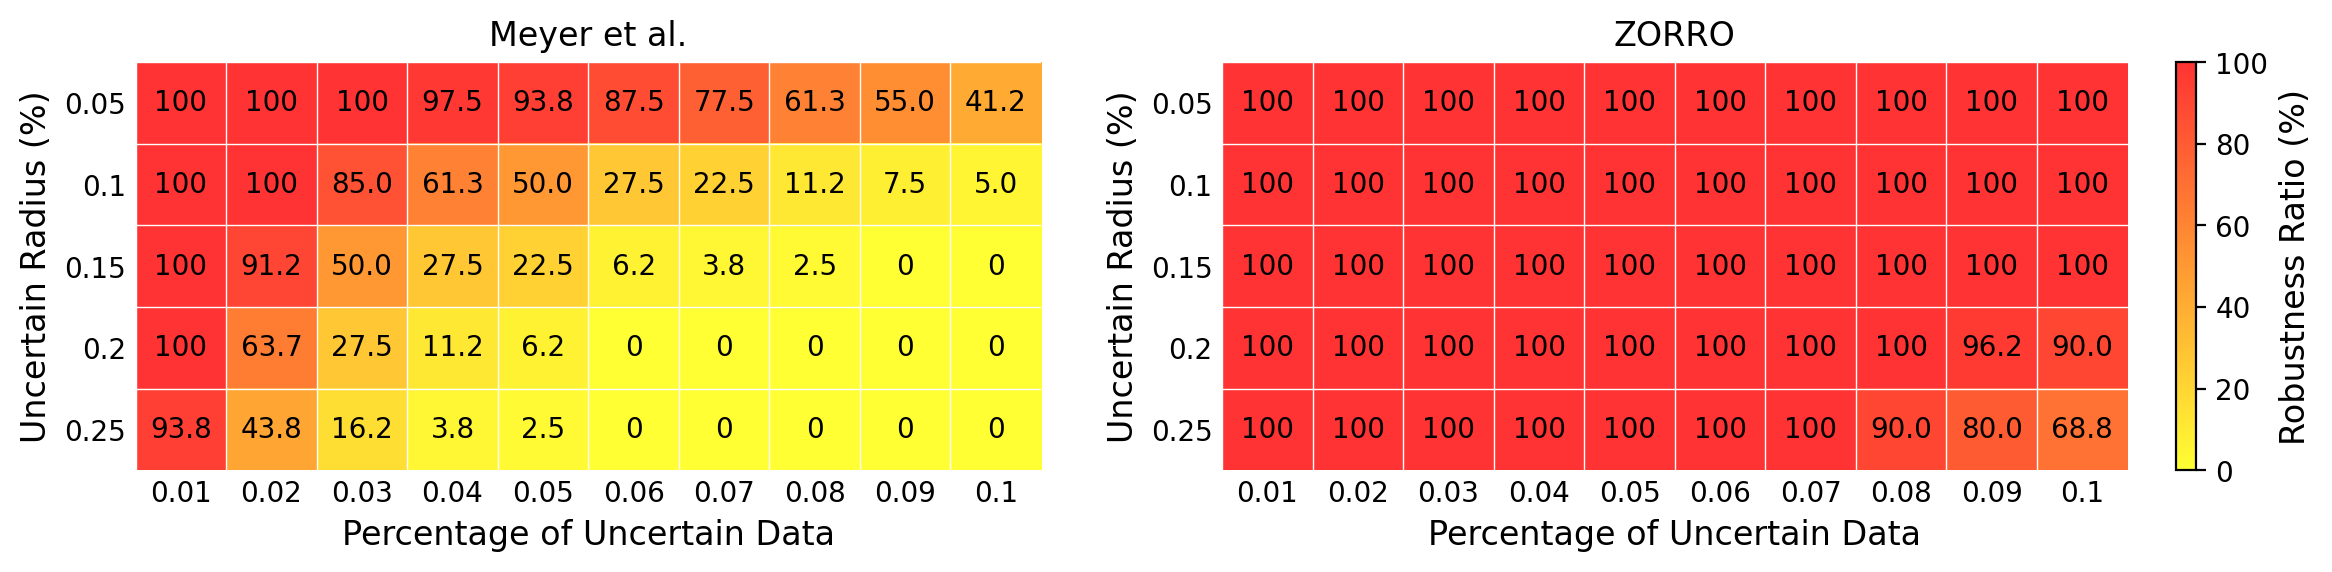

In [21]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('mpg-randomForest-mae-sensitive-heatmap.pdf', bbox_inches='tight')

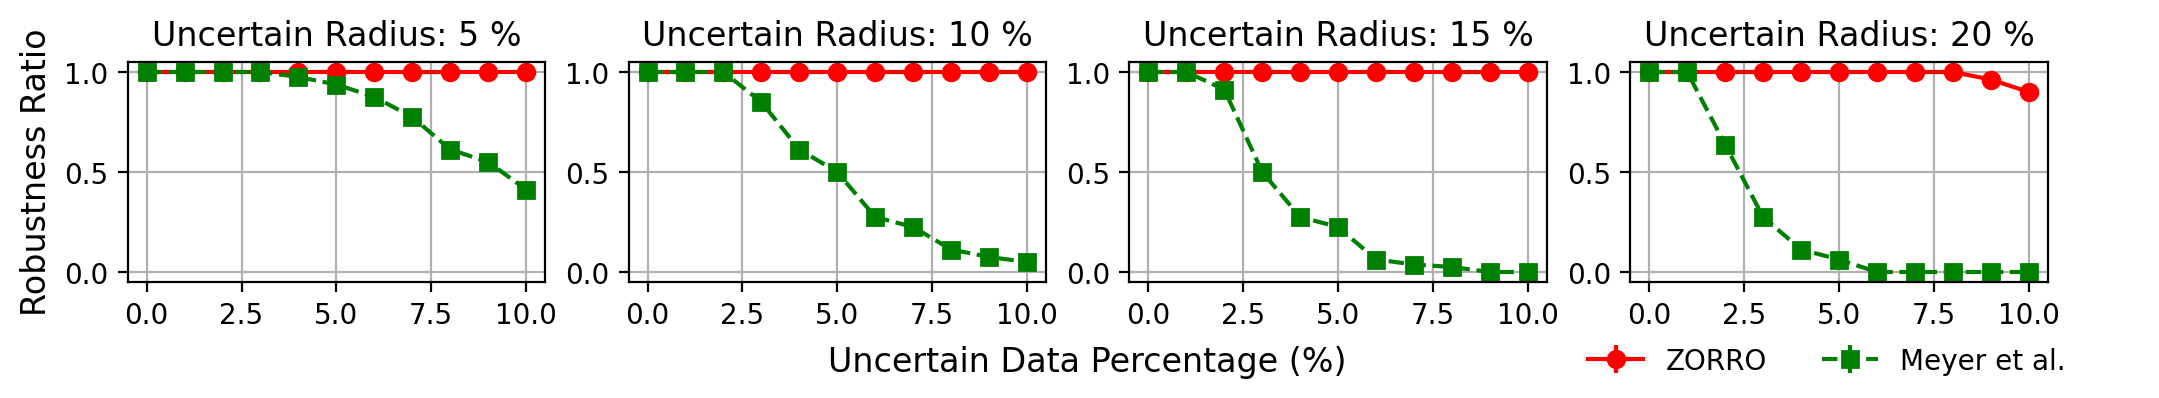

In [22]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-randomForest-mae-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [23]:
# using mse RandomForest
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, rf, mse)
boundary_indices 

[245,
 293,
 148,
 260,
 92,
 274,
 53,
 105,
 79,
 50,
 237,
 99,
 84,
 261,
 198,
 2,
 91,
 250,
 130,
 27,
 238,
 18,
 12,
 138,
 280,
 256,
 51,
 281,
 265,
 126,
 275,
 55,
 6,
 219,
 72,
 194,
 313,
 176,
 227,
 94,
 11,
 39,
 56,
 70,
 235,
 97,
 89,
 170,
 37,
 131,
 285,
 204,
 46,
 167,
 220,
 288,
 315,
 206,
 297,
 96,
 197,
 69,
 28,
 232,
 166,
 172,
 113,
 183,
 317,
 16,
 270,
 158,
 155,
 279,
 266,
 242,
 115,
 7,
 147,
 286,
 102,
 214,
 200,
 188,
 203,
 264,
 312,
 128,
 47,
 22,
 164,
 196,
 66,
 251,
 246,
 112,
 278,
 231,
 287,
 32,
 217,
 209,
 35,
 201,
 252,
 133,
 19,
 149,
 65,
 120,
 316,
 168,
 207,
 154,
 228,
 111,
 276,
 116,
 289,
 210,
 257,
 173,
 248,
 64,
 8,
 104,
 107,
 52,
 175,
 190,
 244,
 13,
 4,
 195,
 42,
 140,
 205,
 174,
 30,
 153,
 41,
 179,
 255,
 213,
 10,
 0,
 212,
 249,
 38,
 121,
 308,
 45,
 292,
 73,
 233,
 222,
 15,
 98,
 269,
 151,
 302,
 108,
 314,
 118,
 144,
 132,
 182,
 272,
 3,
 163,
 221,
 106,
 34,
 25,
 184,
 202,
 74,


In [ ]:
###WOKRING ON ITTTTTTT 
array_indexes = np.zeros(len(X_train))

perc = int(0.1 * len(X_train))

for i in range(perc):
    index = boundary_indices[i]
    array_indexes[index] = 1


mod = DecisionTreeClassifier().fit(X_train, array_indexes)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, _tree

# Fit the DecisionTreeClassifier
#mod = DecisionTreeClassifier().fit(X_train, array_indexes)

# Define function to find positive paths
def get_positive_paths(tree, feature_names, node=0, conditions=None):
    if conditions is None:
        conditions = {}
    
    left_child = tree.children_left[node]
    right_child = tree.children_right[node]
    threshold = tree.threshold[node]
    feature = tree.feature[node]
    
    # Check if it's a leaf node
    if left_child == _tree.TREE_LEAF and right_child == _tree.TREE_LEAF:
        # Check if it's a positive leaf node
        if tree.value[node][0, 1] > tree.value[node][0, 0]:  # More positive than negative
            print("Important Value Threshold Scenario:")
            # Print each feature's range in the conditions
            for feat, bounds in conditions.items():
                lower_bound = bounds.get('lower', '-∞')
                upper_bound = bounds.get('upper', '∞')
                print(f" - {feat}: {lower_bound} < {feat} <= {upper_bound}")
            print()
        return
    
    # Update bounds for the current feature in conditions
    feature_name = feature_names[feature]
    if left_child != _tree.TREE_LEAF:
        # Set an upper bound for the feature
        new_conditions = {k: v.copy() for k, v in conditions.items()}
        new_conditions.setdefault(feature_name, {}).update({'upper': threshold})
        get_positive_paths(tree, feature_names, left_child, new_conditions)
    
    if right_child != _tree.TREE_LEAF:
        # Set a lower bound for the feature
        new_conditions = {k: v.copy() for k, v in conditions.items()}
        new_conditions.setdefault(feature_name, {}).update({'lower': threshold})
        get_positive_paths(tree, feature_names, right_child, new_conditions)

# Define feature names list
feature_names = X_train.columns

# Extract and print paths for positive predictions
get_positive_paths(mod.tree_, feature_names)


In [24]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [26]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


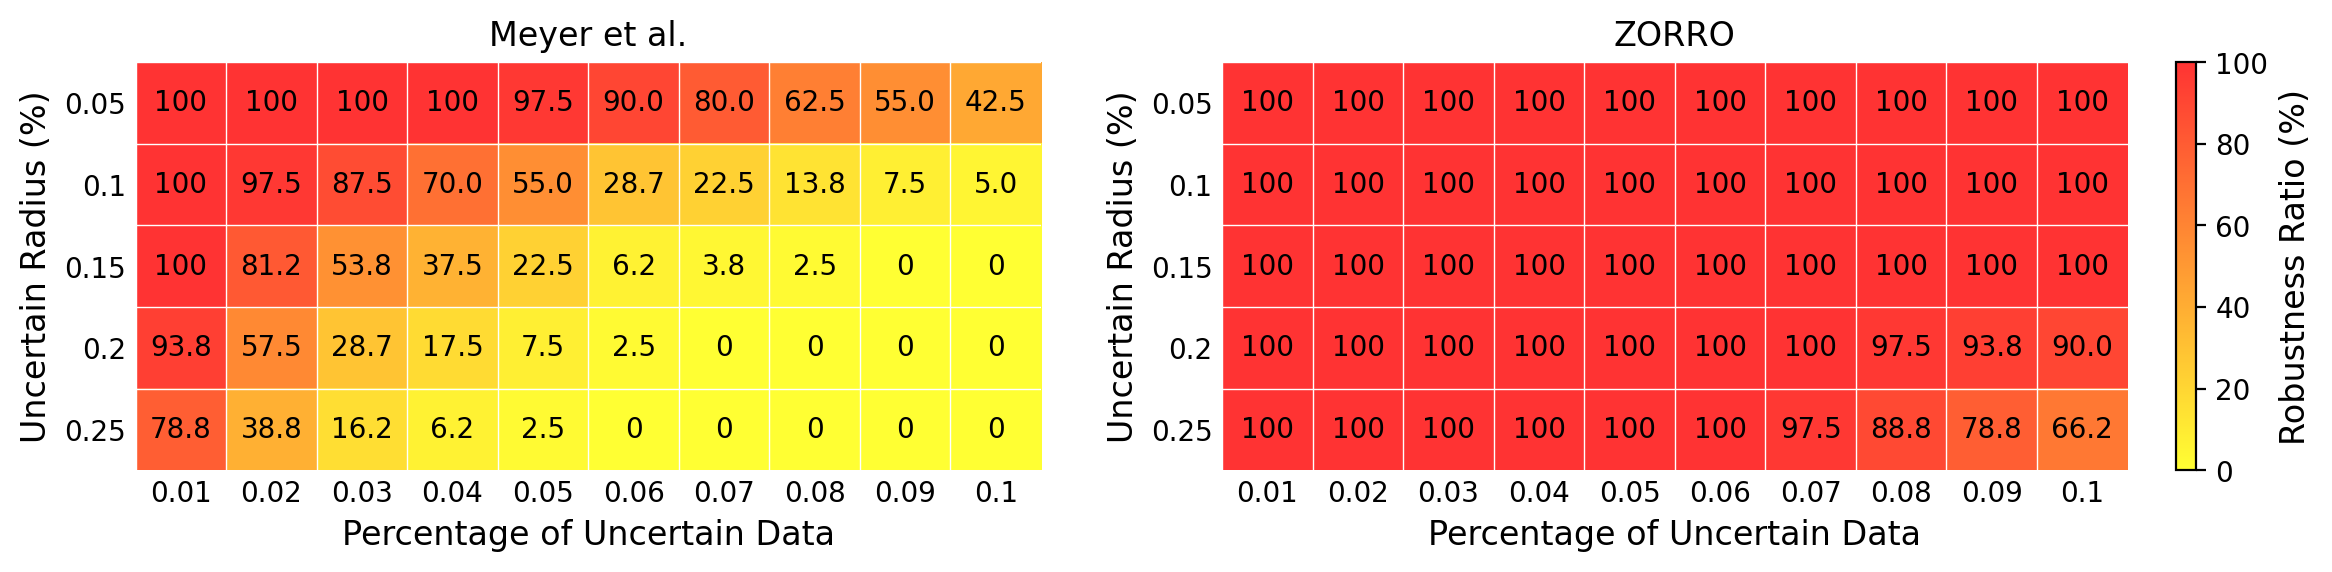

In [27]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('mpg-randomForest-mse-sensitive-heatmap.pdf', bbox_inches='tight')

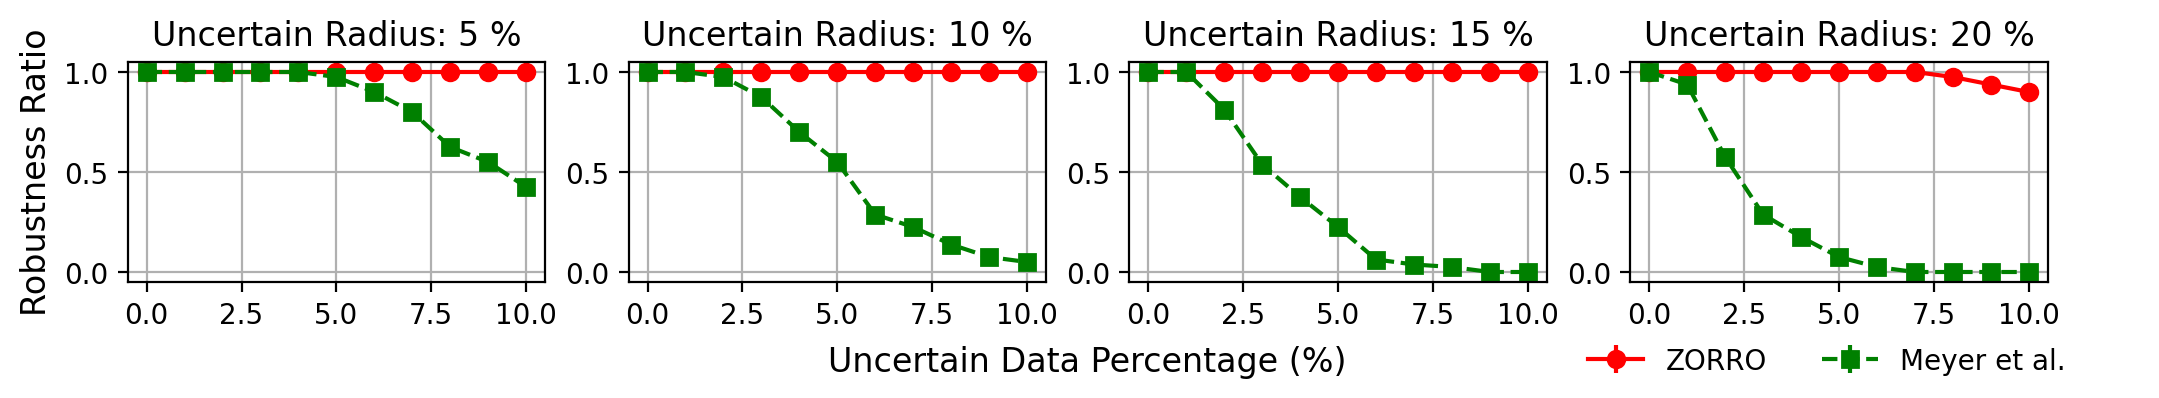

In [28]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-randomForest-mse-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [29]:
#Using r^2, randomForest
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, rf, r_squared)
boundary_indices 

[122,
 109,
 160,
 62,
 283,
 63,
 146,
 14,
 152,
 161,
 229,
 223,
 125,
 145,
 75,
 253,
 5,
 83,
 141,
 299,
 241,
 29,
 100,
 215,
 306,
 267,
 310,
 81,
 157,
 90,
 193,
 301,
 263,
 271,
 33,
 134,
 87,
 277,
 224,
 236,
 309,
 273,
 226,
 57,
 1,
 61,
 101,
 258,
 26,
 291,
 192,
 159,
 24,
 303,
 80,
 225,
 268,
 230,
 142,
 199,
 124,
 262,
 294,
 259,
 54,
 304,
 58,
 169,
 171,
 59,
 185,
 177,
 181,
 114,
 17,
 49,
 44,
 86,
 23,
 211,
 93,
 290,
 150,
 234,
 21,
 137,
 76,
 82,
 162,
 48,
 71,
 239,
 307,
 31,
 85,
 43,
 311,
 135,
 110,
 129,
 78,
 295,
 40,
 218,
 186,
 282,
 300,
 123,
 95,
 298,
 189,
 20,
 247,
 139,
 103,
 243,
 178,
 284,
 36,
 208,
 165,
 143,
 60,
 88,
 67,
 187,
 9,
 305,
 136,
 191,
 296,
 216,
 68,
 254,
 119,
 156,
 117,
 77,
 127,
 240,
 180,
 74,
 202,
 184,
 25,
 34,
 106,
 221,
 163,
 3,
 272,
 182,
 132,
 144,
 118,
 314,
 108,
 302,
 151,
 269,
 98,
 15,
 222,
 233,
 73,
 292,
 45,
 308,
 121,
 38,
 249,
 212,
 0,
 10,
 213,
 255,
 179,

In [30]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [31]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


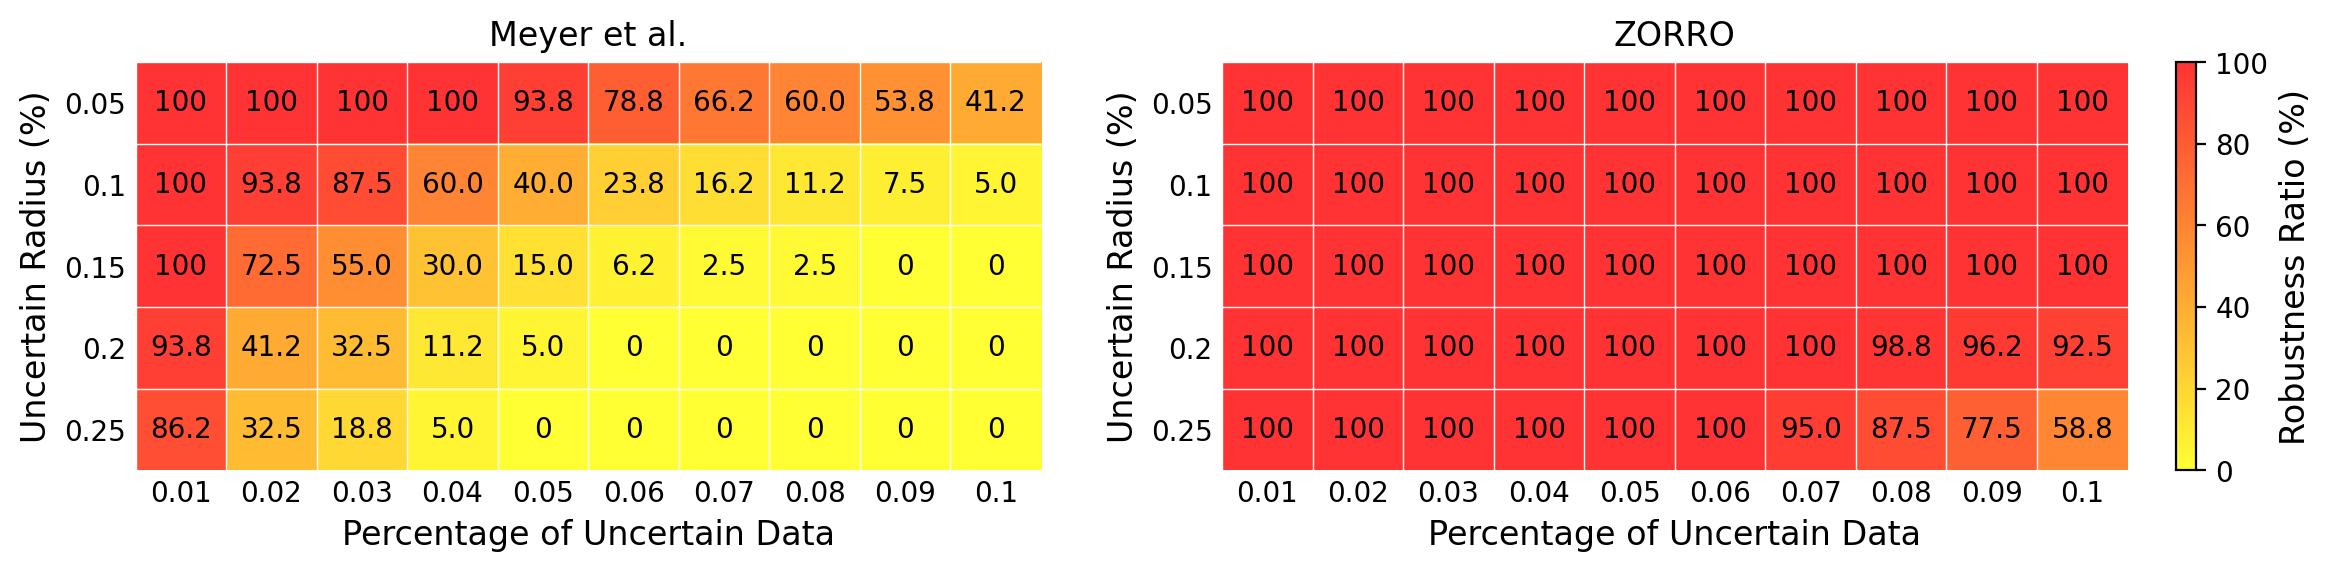

In [33]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('r2-randomForest-mpg-sensitive-heatmap.pdf', bbox_inches='tight')

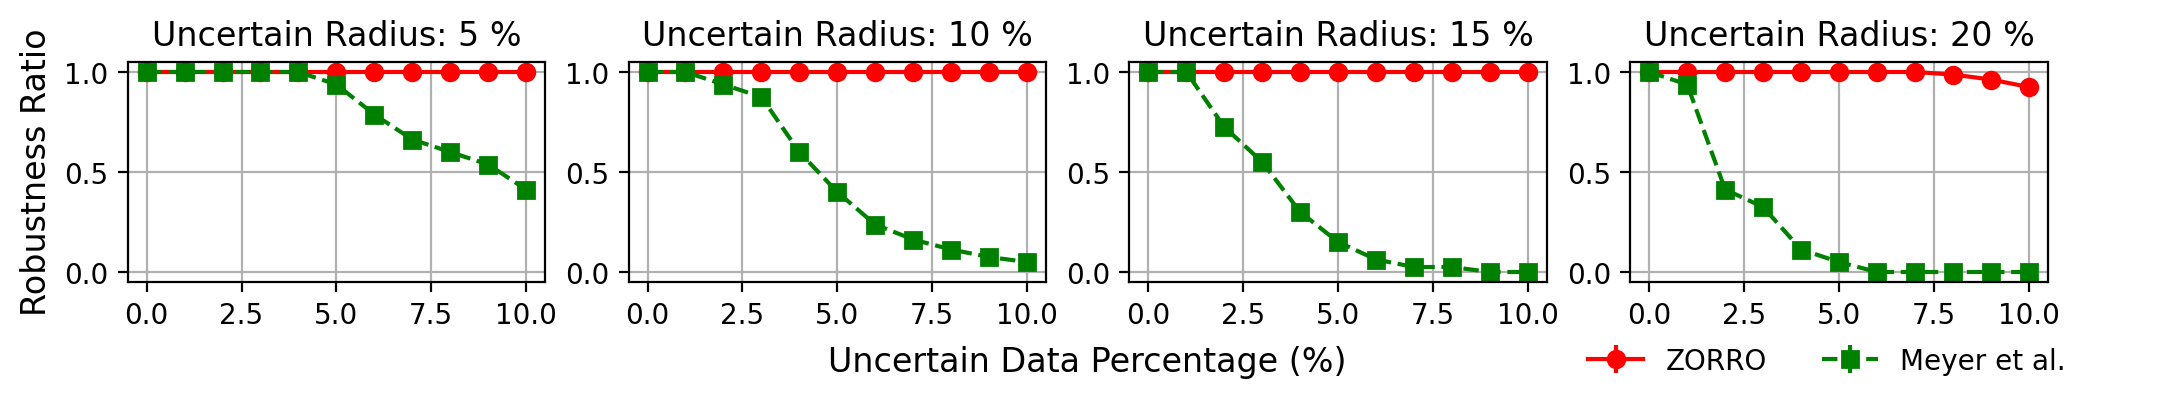

In [34]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-r2-RandomForest-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [35]:
#Using rmse, randomforest:
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, rf, rmse)
boundary_indices 

[245,
 293,
 148,
 260,
 92,
 274,
 53,
 105,
 79,
 50,
 237,
 99,
 84,
 261,
 198,
 2,
 91,
 250,
 130,
 27,
 238,
 18,
 12,
 138,
 280,
 256,
 51,
 281,
 265,
 126,
 275,
 55,
 6,
 219,
 72,
 194,
 313,
 176,
 227,
 94,
 11,
 39,
 56,
 70,
 235,
 97,
 89,
 170,
 37,
 131,
 285,
 204,
 46,
 167,
 220,
 288,
 315,
 206,
 297,
 96,
 197,
 69,
 28,
 232,
 166,
 172,
 113,
 183,
 317,
 16,
 270,
 158,
 155,
 279,
 266,
 242,
 115,
 7,
 147,
 286,
 102,
 214,
 200,
 188,
 203,
 264,
 312,
 128,
 47,
 22,
 164,
 196,
 66,
 251,
 246,
 112,
 278,
 231,
 287,
 32,
 217,
 209,
 35,
 201,
 252,
 133,
 19,
 149,
 65,
 120,
 316,
 168,
 207,
 154,
 228,
 111,
 276,
 116,
 289,
 210,
 257,
 173,
 248,
 64,
 8,
 104,
 107,
 52,
 175,
 190,
 244,
 13,
 4,
 195,
 42,
 140,
 205,
 174,
 30,
 153,
 41,
 179,
 255,
 213,
 10,
 0,
 212,
 249,
 38,
 121,
 308,
 45,
 292,
 73,
 233,
 222,
 15,
 98,
 269,
 151,
 302,
 108,
 314,
 118,
 144,
 132,
 182,
 272,
 3,
 163,
 221,
 106,
 34,
 25,
 184,
 202,
 74,


In [36]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [37]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [38]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


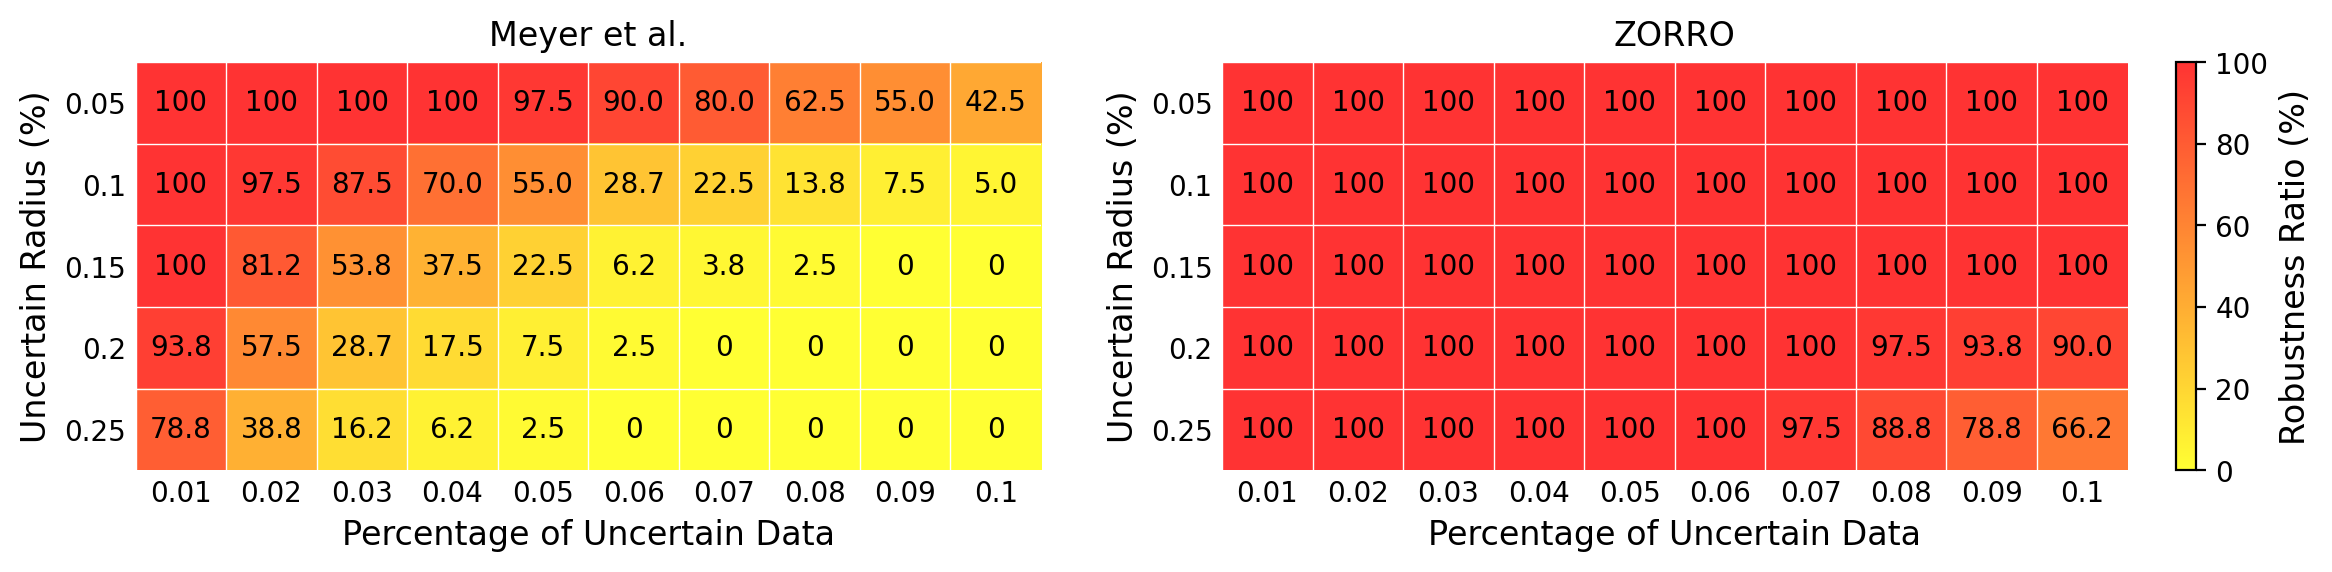

In [39]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('rmse-randomForest-mpg-sensitive-heatmap.pdf', bbox_inches='tight')

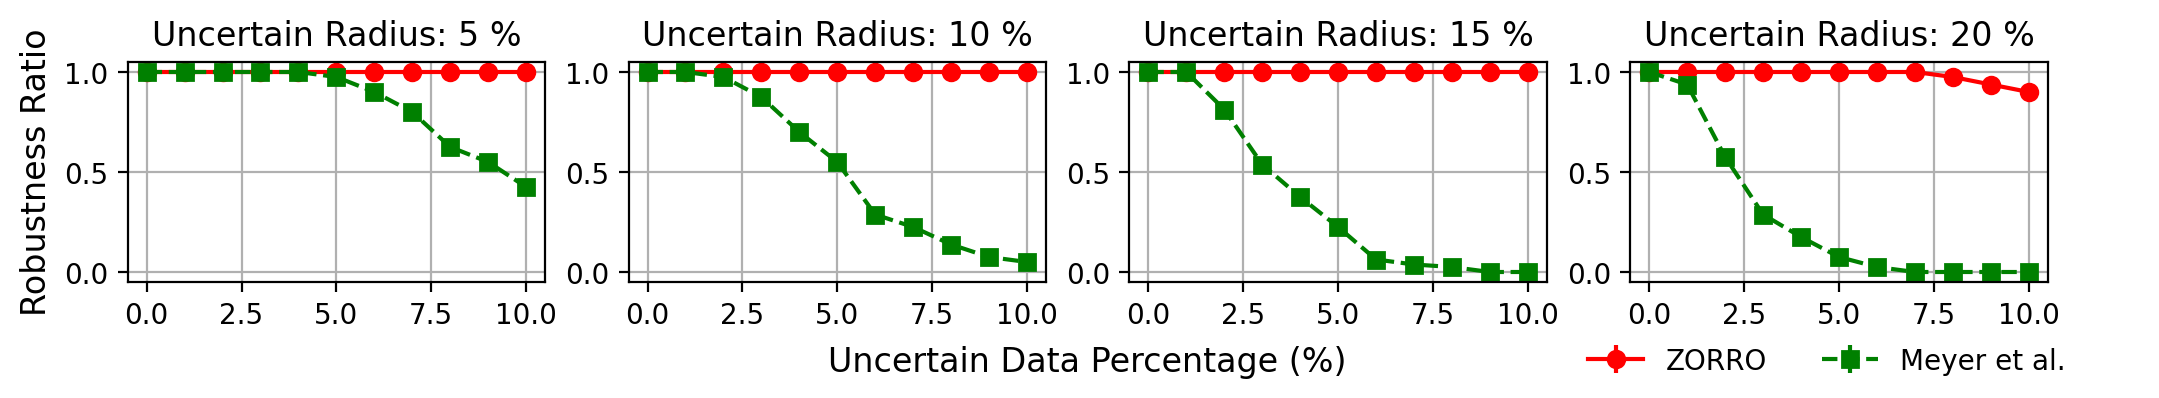

In [40]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-rmse-RandomForest-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [41]:
#Using mae, LinearRegression
lr = LinearRegression()
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, lr, mae)
boundary_indices 

[118,
 291,
 19,
 108,
 175,
 305,
 84,
 285,
 278,
 148,
 230,
 252,
 272,
 204,
 103,
 36,
 220,
 81,
 21,
 298,
 66,
 249,
 221,
 262,
 193,
 80,
 302,
 250,
 7,
 283,
 29,
 288,
 25,
 236,
 160,
 233,
 10,
 232,
 229,
 64,
 124,
 138,
 76,
 185,
 263,
 223,
 69,
 270,
 102,
 247,
 75,
 299,
 70,
 258,
 257,
 265,
 8,
 300,
 177,
 4,
 71,
 208,
 27,
 295,
 296,
 166,
 269,
 92,
 179,
 142,
 110,
 281,
 275,
 297,
 231,
 164,
 286,
 159,
 264,
 214,
 292,
 143,
 74,
 51,
 235,
 273,
 132,
 192,
 119,
 154,
 89,
 284,
 201,
 43,
 199,
 176,
 49,
 163,
 274,
 260,
 313,
 79,
 315,
 294,
 194,
 218,
 188,
 44,
 151,
 127,
 197,
 41,
 62,
 222,
 59,
 35,
 226,
 6,
 5,
 46,
 168,
 215,
 12,
 317,
 167,
 316,
 181,
 182,
 67,
 261,
 82,
 239,
 253,
 161,
 209,
 60,
 280,
 195,
 128,
 115,
 31,
 114,
 308,
 107,
 248,
 254,
 256,
 47,
 186,
 133,
 282,
 238,
 202,
 183,
 184,
 304,
 106,
 20,
 171,
 251,
 178,
 311,
 24,
 87,
 196,
 101,
 244,
 145,
 200,
 135,
 290,
 211,
 55,
 259,
 217,


In [42]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [44]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


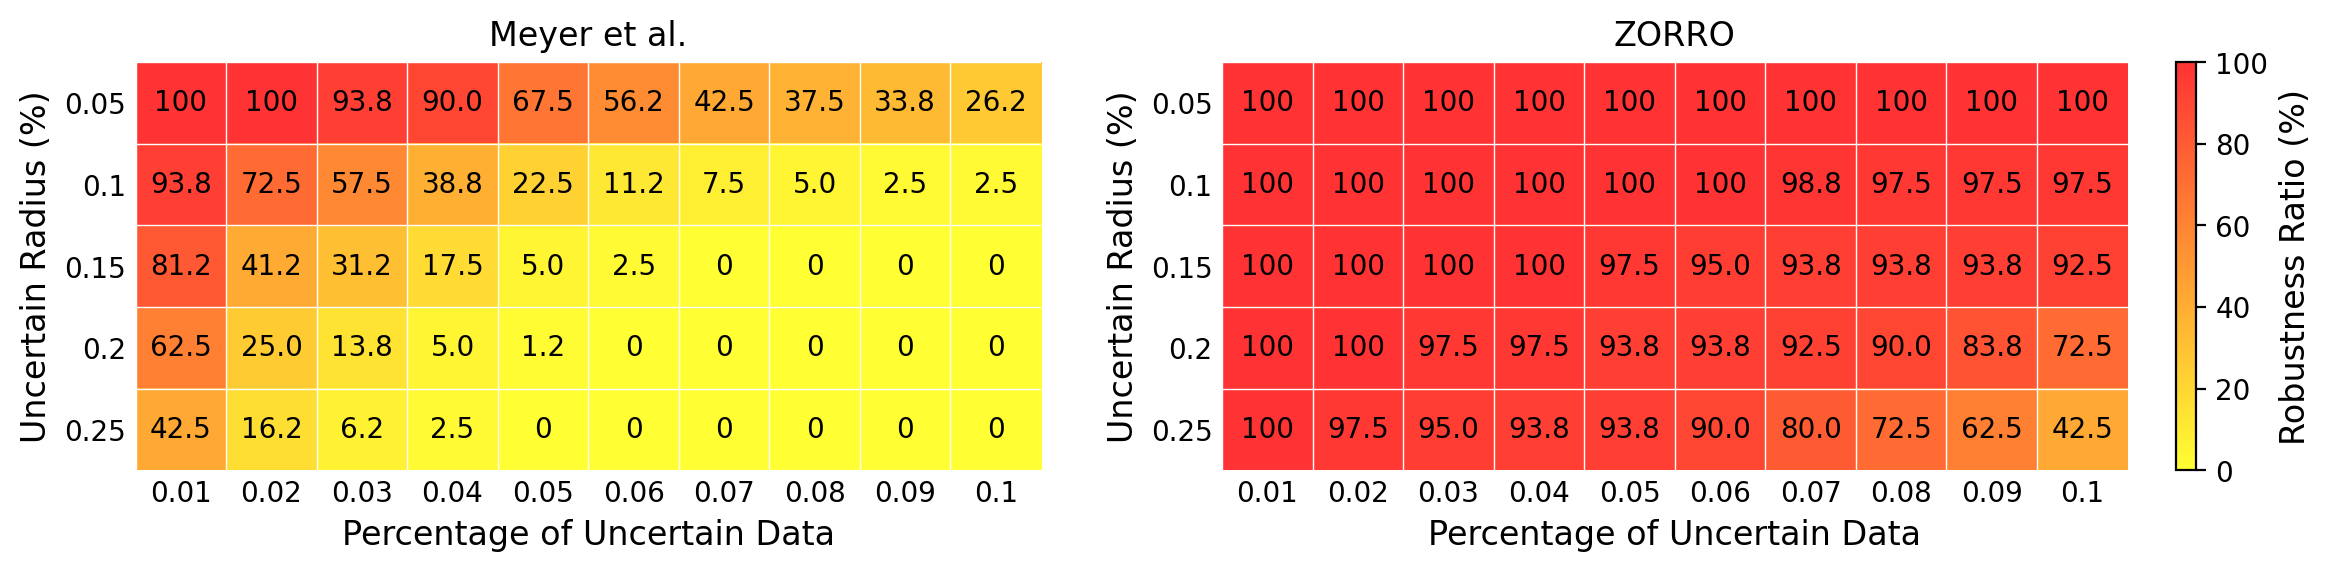

In [45]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('mpg-linear-mae-sensitive-heatmap.pdf', bbox_inches='tight')

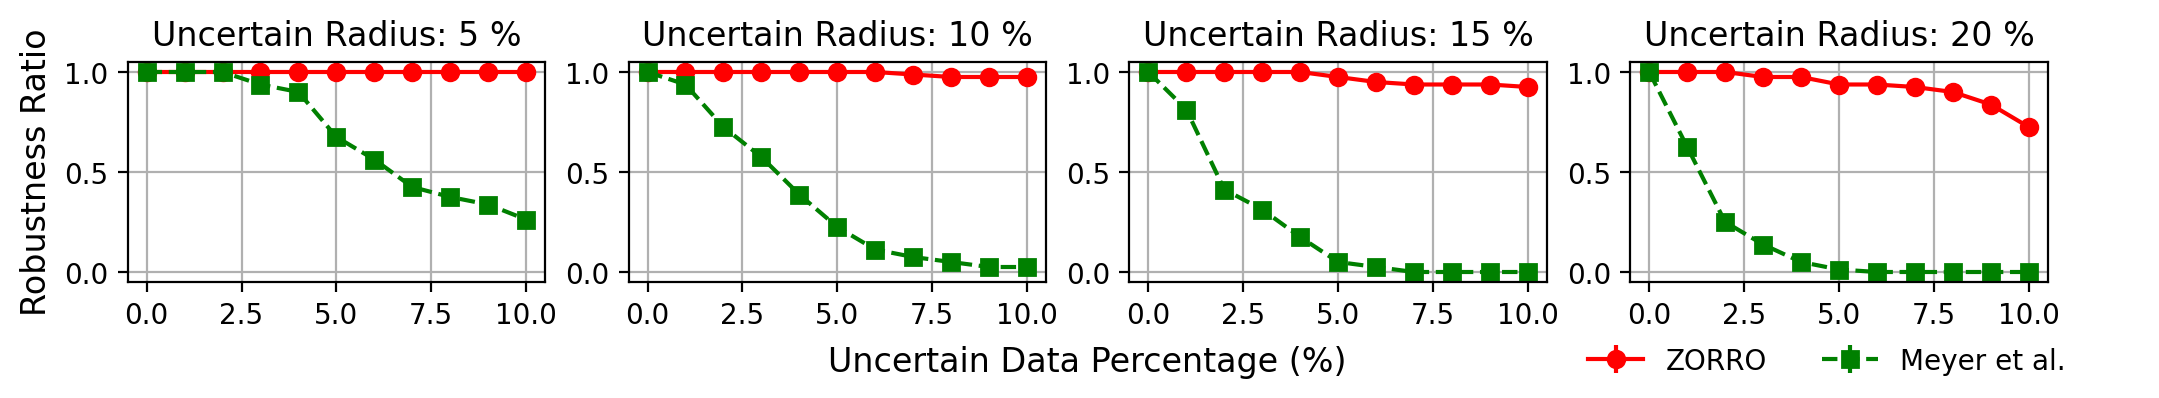

In [46]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-linear-mae-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [47]:
#Using mse, LinearRegression
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, lr, mse)
boundary_indices 

[118,
 291,
 108,
 19,
 175,
 305,
 84,
 148,
 204,
 285,
 262,
 272,
 193,
 249,
 21,
 36,
 252,
 220,
 302,
 278,
 103,
 283,
 66,
 230,
 298,
 80,
 233,
 25,
 7,
 124,
 29,
 288,
 81,
 8,
 221,
 138,
 232,
 75,
 185,
 64,
 299,
 270,
 10,
 102,
 160,
 258,
 236,
 76,
 166,
 263,
 247,
 71,
 223,
 164,
 257,
 295,
 229,
 250,
 231,
 27,
 177,
 208,
 296,
 179,
 31,
 92,
 110,
 69,
 300,
 281,
 74,
 297,
 275,
 159,
 286,
 119,
 4,
 142,
 199,
 49,
 292,
 273,
 51,
 176,
 313,
 132,
 260,
 192,
 194,
 89,
 82,
 163,
 265,
 70,
 264,
 294,
 43,
 154,
 114,
 12,
 209,
 274,
 188,
 127,
 301,
 59,
 44,
 143,
 308,
 6,
 56,
 235,
 197,
 226,
 201,
 155,
 67,
 46,
 214,
 218,
 222,
 261,
 35,
 315,
 195,
 182,
 167,
 317,
 254,
 268,
 11,
 184,
 280,
 5,
 107,
 115,
 200,
 186,
 128,
 256,
 168,
 60,
 245,
 96,
 238,
 259,
 314,
 145,
 304,
 183,
 47,
 202,
 133,
 162,
 178,
 311,
 140,
 14,
 215,
 171,
 251,
 196,
 290,
 244,
 253,
 211,
 79,
 219,
 24,
 99,
 87,
 151,
 97,
 55,
 276,
 14

In [48]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [49]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [50]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


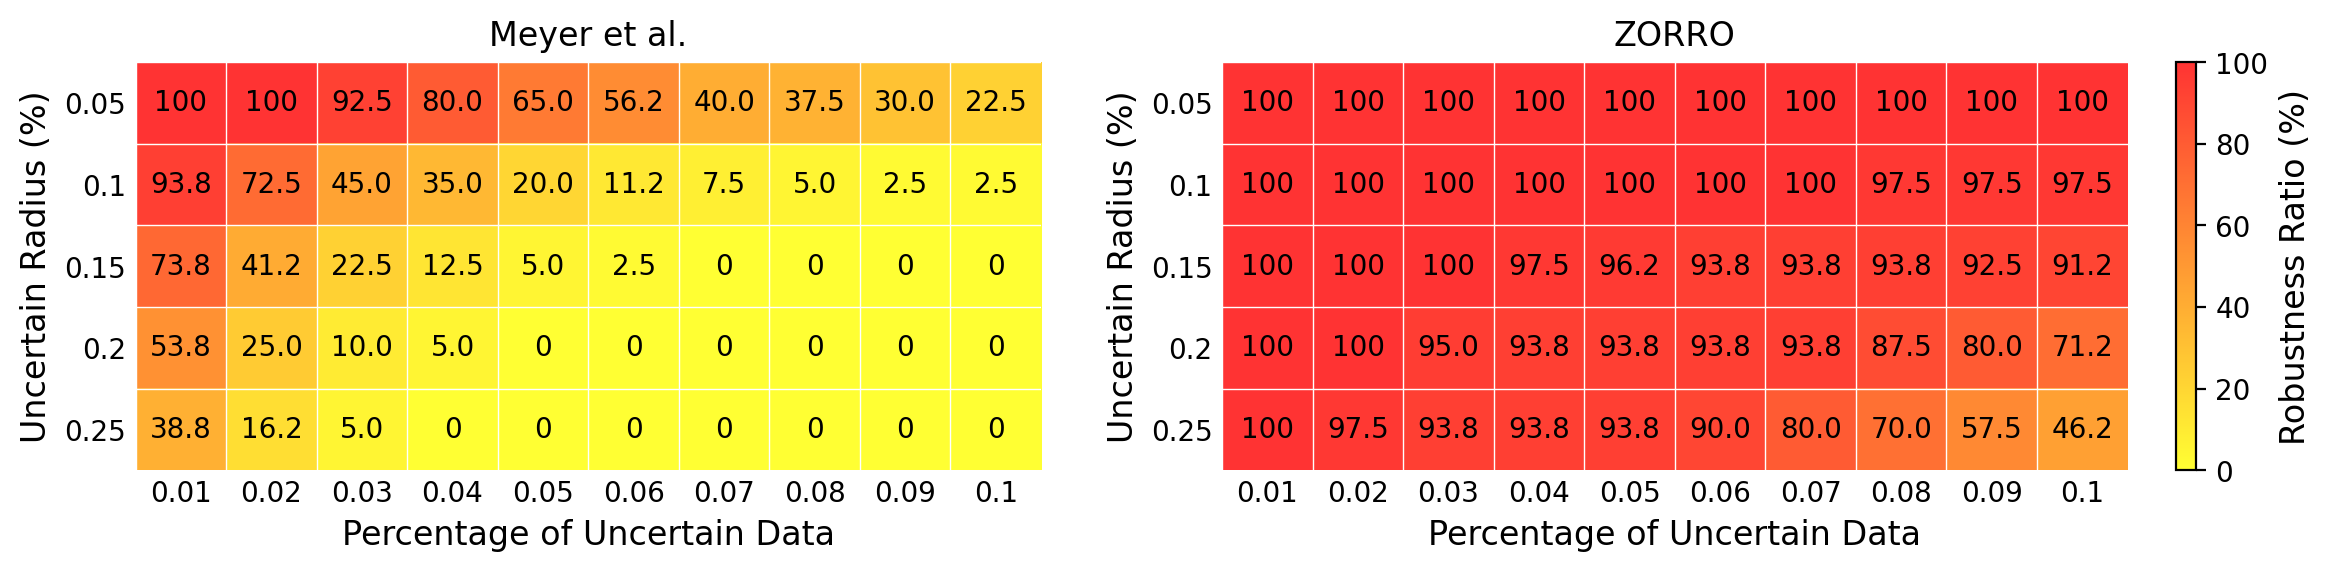

In [51]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('mpg-linear-mse-sensitive-heatmap.pdf', bbox_inches='tight')

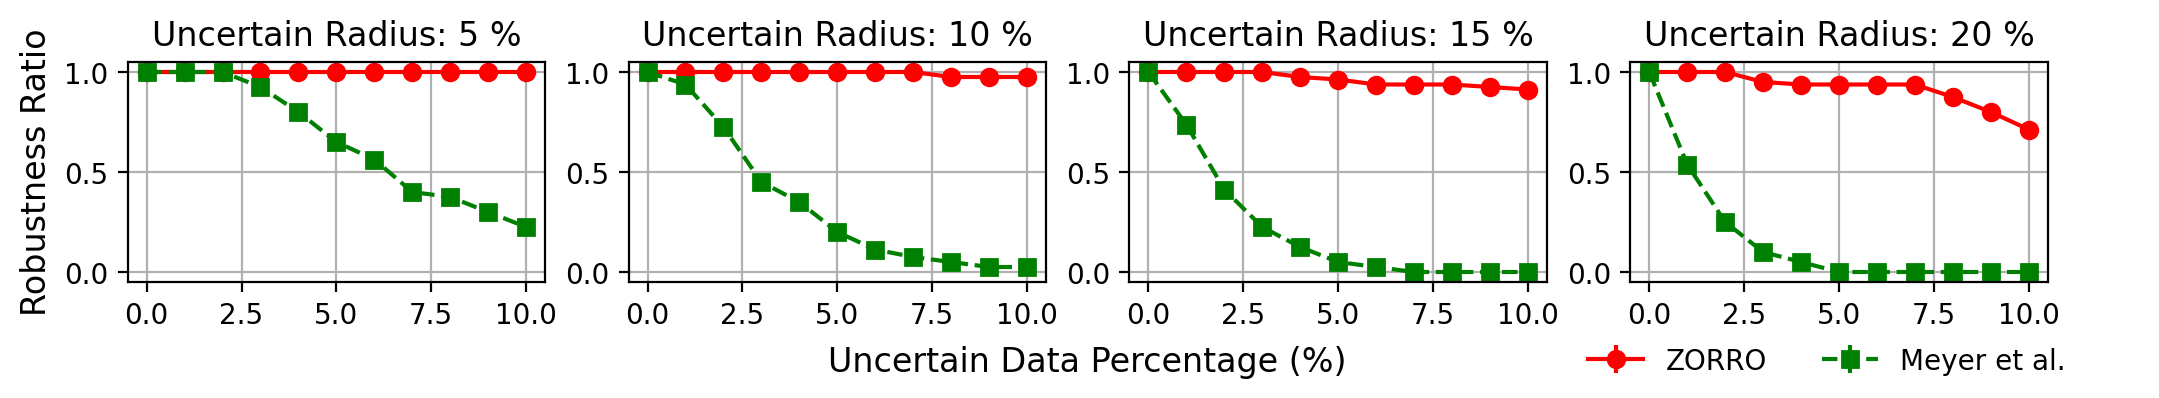

In [52]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-linear-mse-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [53]:
#Using r_squared, LinearRegression
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, lr, r_squared)
boundary_indices 

[63,
 1,
 198,
 277,
 210,
 144,
 307,
 100,
 28,
 113,
 112,
 116,
 240,
 109,
 131,
 98,
 32,
 149,
 147,
 57,
 54,
 40,
 129,
 90,
 237,
 174,
 34,
 95,
 137,
 42,
 216,
 169,
 271,
 158,
 227,
 203,
 58,
 228,
 65,
 18,
 303,
 0,
 50,
 48,
 37,
 88,
 3,
 61,
 213,
 91,
 189,
 122,
 9,
 23,
 170,
 123,
 78,
 224,
 241,
 289,
 150,
 26,
 212,
 52,
 45,
 267,
 134,
 94,
 225,
 266,
 234,
 190,
 316,
 121,
 172,
 205,
 306,
 77,
 156,
 284,
 106,
 2,
 248,
 310,
 125,
 246,
 38,
 141,
 53,
 165,
 41,
 30,
 104,
 279,
 161,
 13,
 242,
 181,
 15,
 207,
 68,
 173,
 243,
 72,
 83,
 105,
 130,
 152,
 126,
 120,
 86,
 269,
 111,
 33,
 309,
 17,
 93,
 191,
 217,
 136,
 187,
 20,
 206,
 139,
 157,
 39,
 73,
 293,
 62,
 312,
 239,
 135,
 85,
 282,
 180,
 153,
 117,
 287,
 255,
 22,
 16,
 101,
 146,
 276,
 55,
 97,
 151,
 87,
 99,
 24,
 219,
 79,
 211,
 253,
 244,
 290,
 196,
 251,
 171,
 215,
 14,
 140,
 311,
 178,
 162,
 133,
 202,
 47,
 183,
 304,
 145,
 314,
 259,
 238,
 96,
 245,
 60,
 168,

In [54]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [55]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [56]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


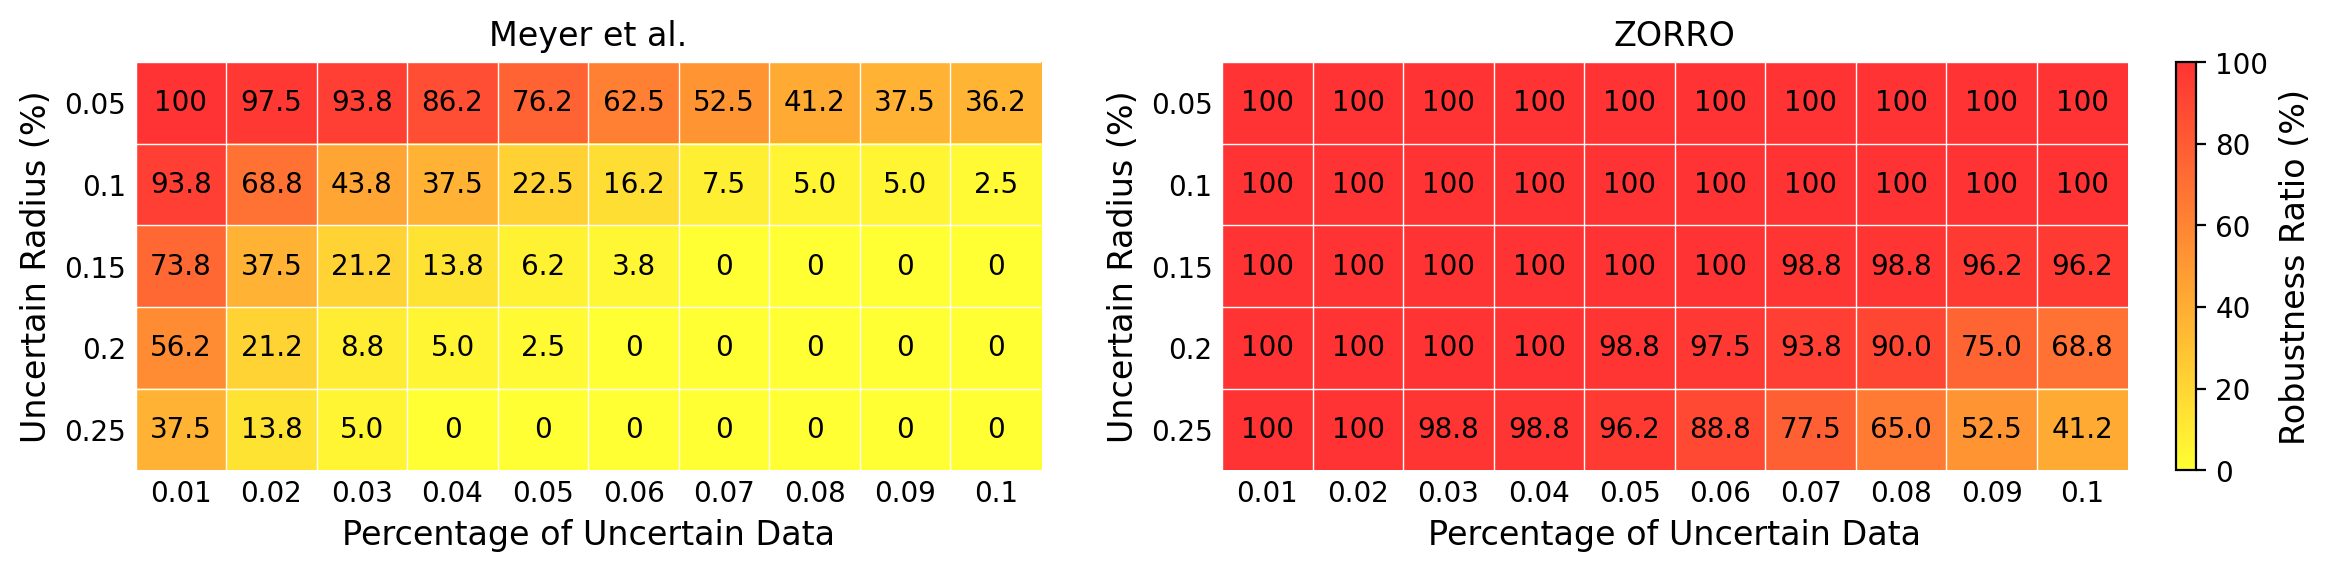

In [57]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('mpg-linear-r-squared-sensitive-heatmap.pdf', bbox_inches='tight')

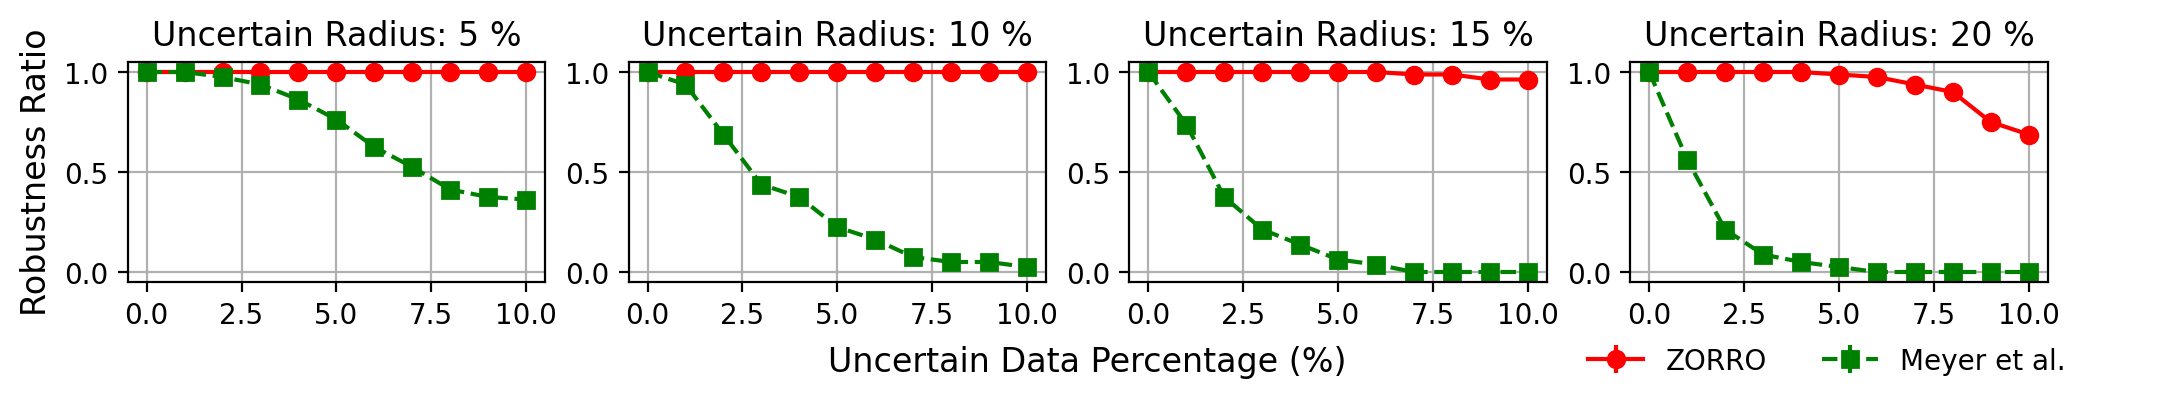

In [58]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-linear-r-squared-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [59]:
#Using rmse, LinearRegression
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, lr, rmse)
boundary_indices 

[118,
 291,
 108,
 19,
 175,
 305,
 84,
 148,
 204,
 285,
 262,
 272,
 193,
 249,
 21,
 36,
 252,
 220,
 302,
 278,
 103,
 283,
 66,
 230,
 298,
 80,
 233,
 25,
 7,
 124,
 29,
 288,
 81,
 8,
 221,
 138,
 232,
 75,
 185,
 64,
 299,
 270,
 10,
 102,
 160,
 258,
 236,
 76,
 166,
 263,
 247,
 71,
 223,
 164,
 257,
 295,
 229,
 250,
 231,
 27,
 177,
 208,
 296,
 179,
 31,
 92,
 110,
 69,
 300,
 281,
 74,
 297,
 275,
 159,
 286,
 119,
 4,
 142,
 199,
 49,
 292,
 273,
 51,
 176,
 313,
 132,
 260,
 192,
 194,
 89,
 82,
 163,
 265,
 70,
 264,
 294,
 43,
 154,
 114,
 12,
 209,
 274,
 188,
 127,
 301,
 59,
 44,
 143,
 308,
 6,
 56,
 235,
 197,
 226,
 201,
 155,
 67,
 46,
 214,
 218,
 222,
 261,
 35,
 315,
 195,
 182,
 167,
 317,
 254,
 268,
 11,
 184,
 280,
 5,
 107,
 115,
 200,
 186,
 128,
 256,
 168,
 60,
 245,
 96,
 238,
 259,
 314,
 145,
 304,
 183,
 47,
 202,
 133,
 162,
 178,
 311,
 140,
 14,
 215,
 171,
 251,
 196,
 290,
 244,
 253,
 211,
 79,
 219,
 24,
 99,
 87,
 151,
 97,
 55,
 276,
 14

In [60]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [61]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [62]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


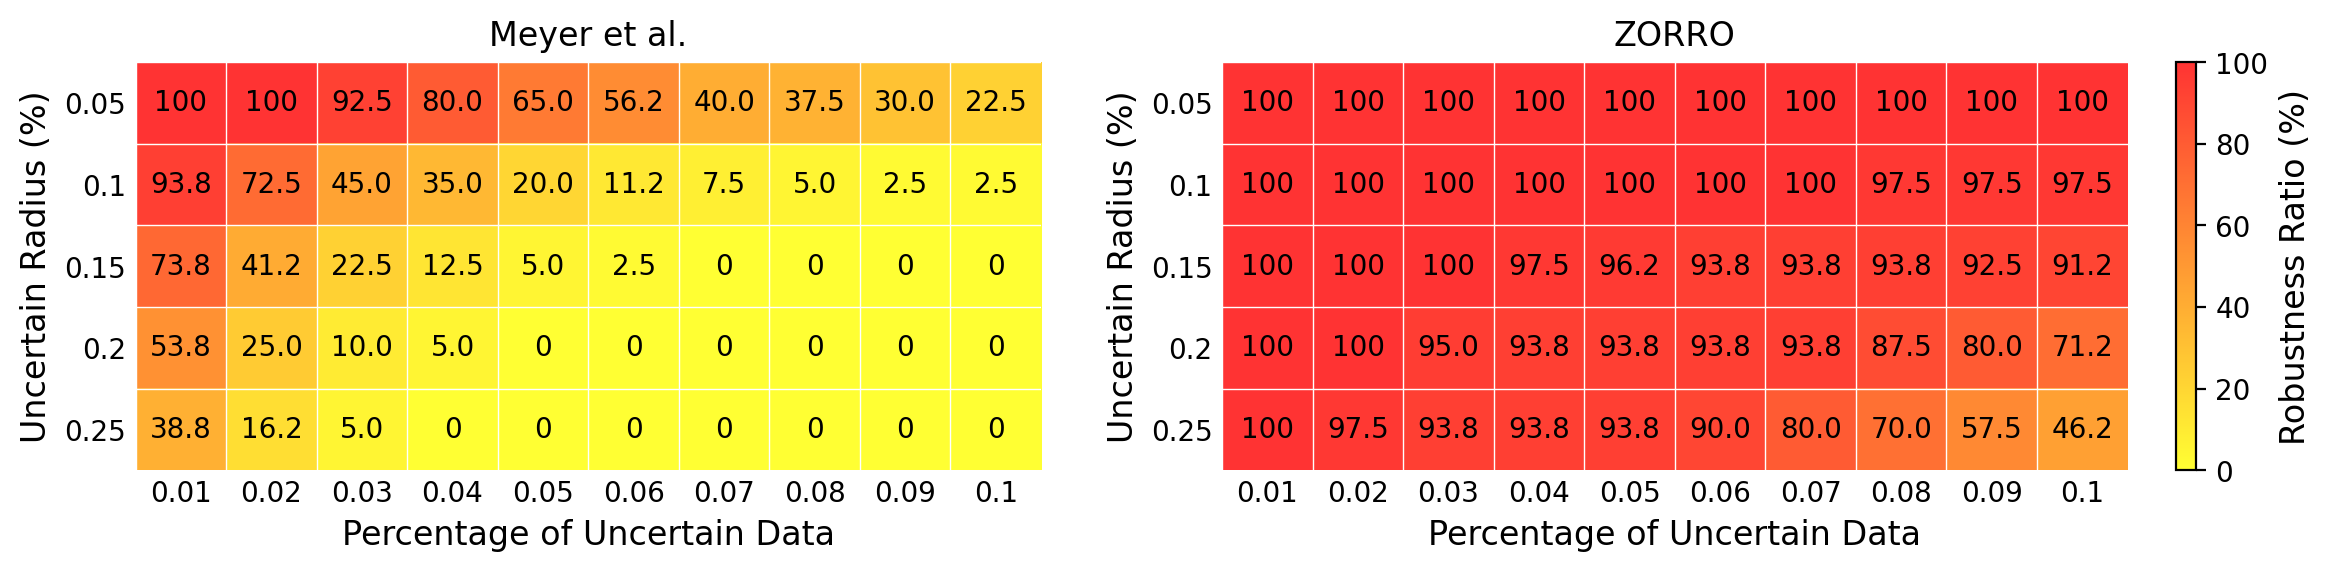

In [63]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('mpg-linear-rmse-sensitive-heatmap.pdf', bbox_inches='tight')

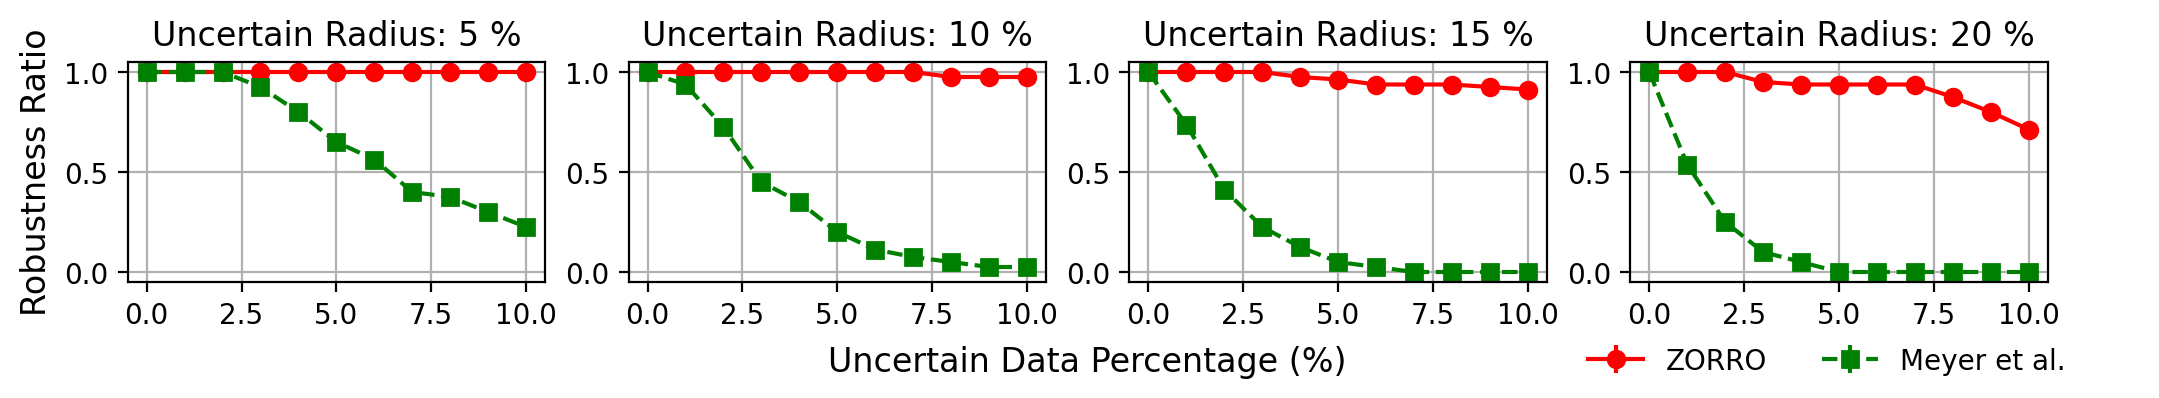

In [64]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-linear-rmse-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [65]:
#Using mae, Ridge
ridge = Ridge(alpha=1.0)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, ridge, mae)
boundary_indices

[118,
 291,
 19,
 108,
 175,
 305,
 84,
 285,
 278,
 148,
 230,
 252,
 272,
 204,
 103,
 36,
 220,
 81,
 249,
 298,
 221,
 66,
 21,
 193,
 262,
 80,
 302,
 250,
 7,
 283,
 29,
 288,
 25,
 236,
 160,
 233,
 10,
 232,
 229,
 124,
 138,
 64,
 185,
 263,
 223,
 76,
 69,
 102,
 75,
 247,
 270,
 299,
 258,
 70,
 257,
 8,
 300,
 177,
 4,
 265,
 208,
 27,
 295,
 71,
 296,
 166,
 92,
 269,
 179,
 142,
 110,
 275,
 281,
 231,
 297,
 164,
 286,
 214,
 159,
 292,
 264,
 143,
 51,
 74,
 235,
 273,
 132,
 119,
 192,
 89,
 154,
 284,
 43,
 201,
 199,
 260,
 313,
 274,
 79,
 49,
 176,
 163,
 294,
 194,
 315,
 218,
 188,
 44,
 127,
 151,
 197,
 41,
 59,
 226,
 35,
 6,
 5,
 46,
 62,
 222,
 168,
 215,
 12,
 317,
 316,
 181,
 182,
 67,
 261,
 253,
 209,
 82,
 60,
 167,
 280,
 195,
 128,
 239,
 115,
 161,
 114,
 308,
 31,
 107,
 254,
 256,
 47,
 186,
 133,
 282,
 238,
 202,
 183,
 248,
 184,
 304,
 20,
 171,
 311,
 178,
 251,
 24,
 87,
 196,
 101,
 244,
 145,
 200,
 135,
 211,
 290,
 55,
 259,
 180,
 217,


In [66]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [67]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [68]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


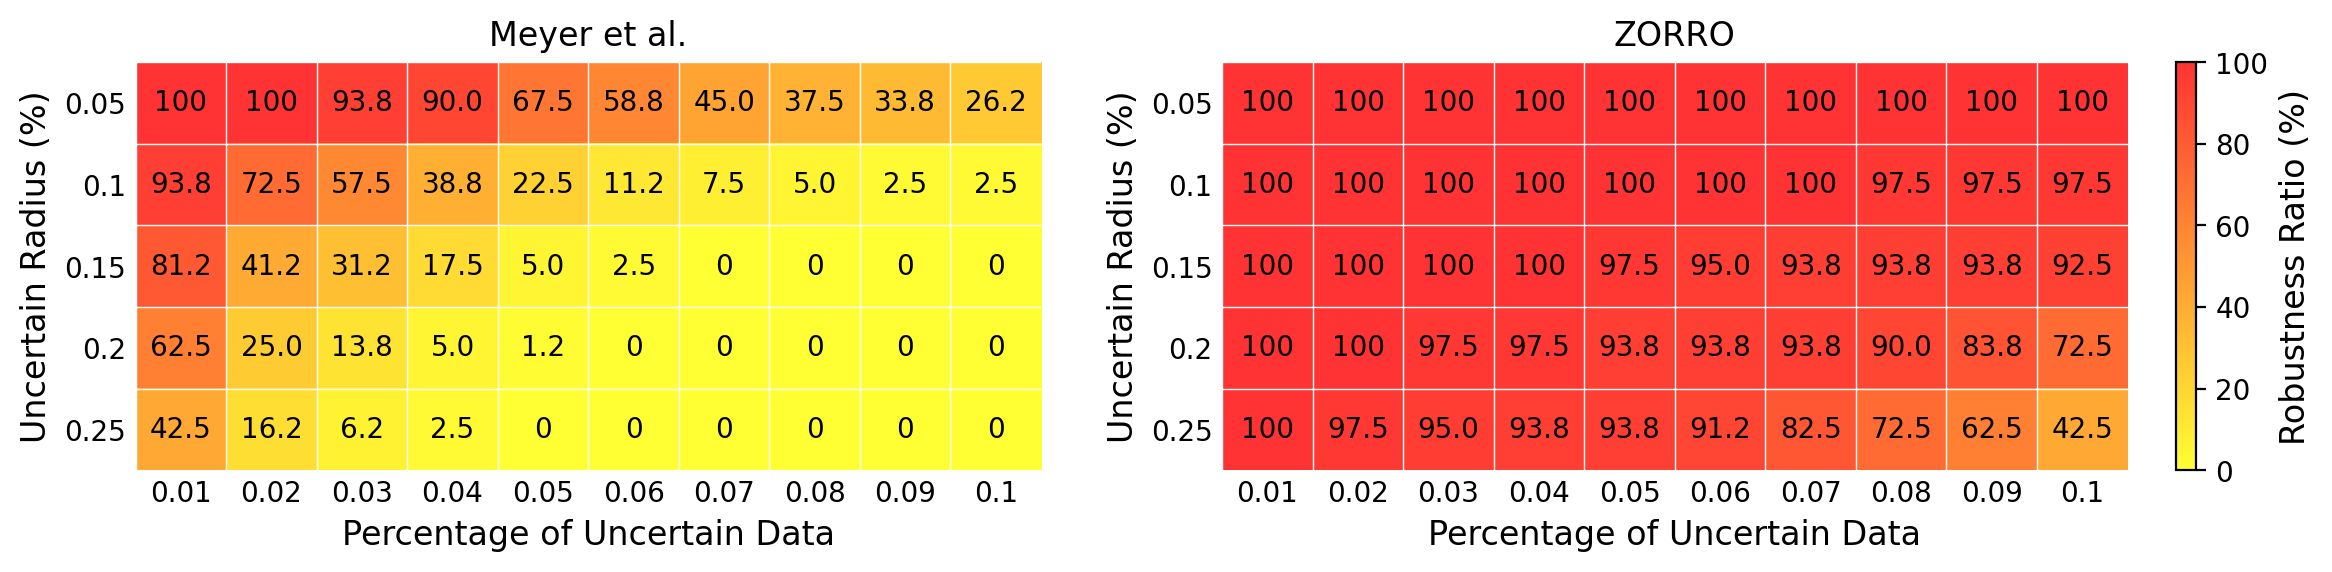

In [69]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('mpg-ridge-mae-sensitive-heatmap.pdf', bbox_inches='tight')

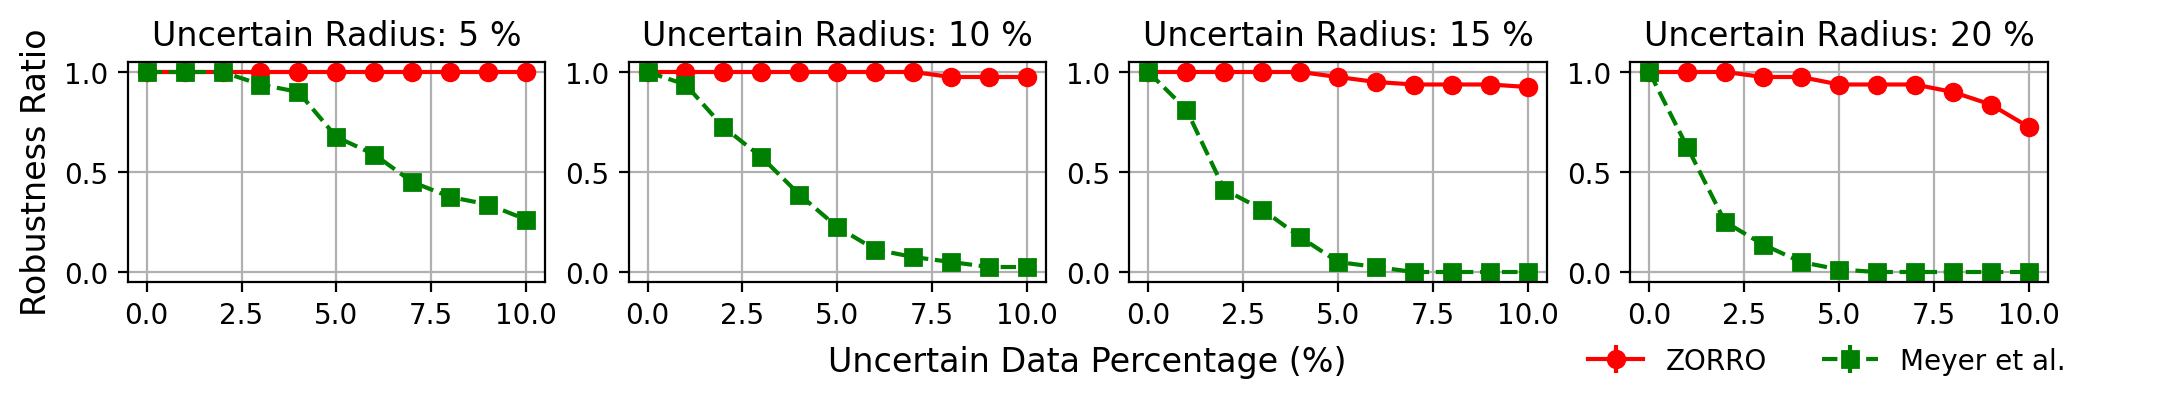

In [70]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-ridge-mae-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [ ]:
#Using r2, Ridge
ridge = Ridge(alpha=1.0)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, ridge, r_squared)
boundary_indices

In [ ]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

In [ ]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

In [ ]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


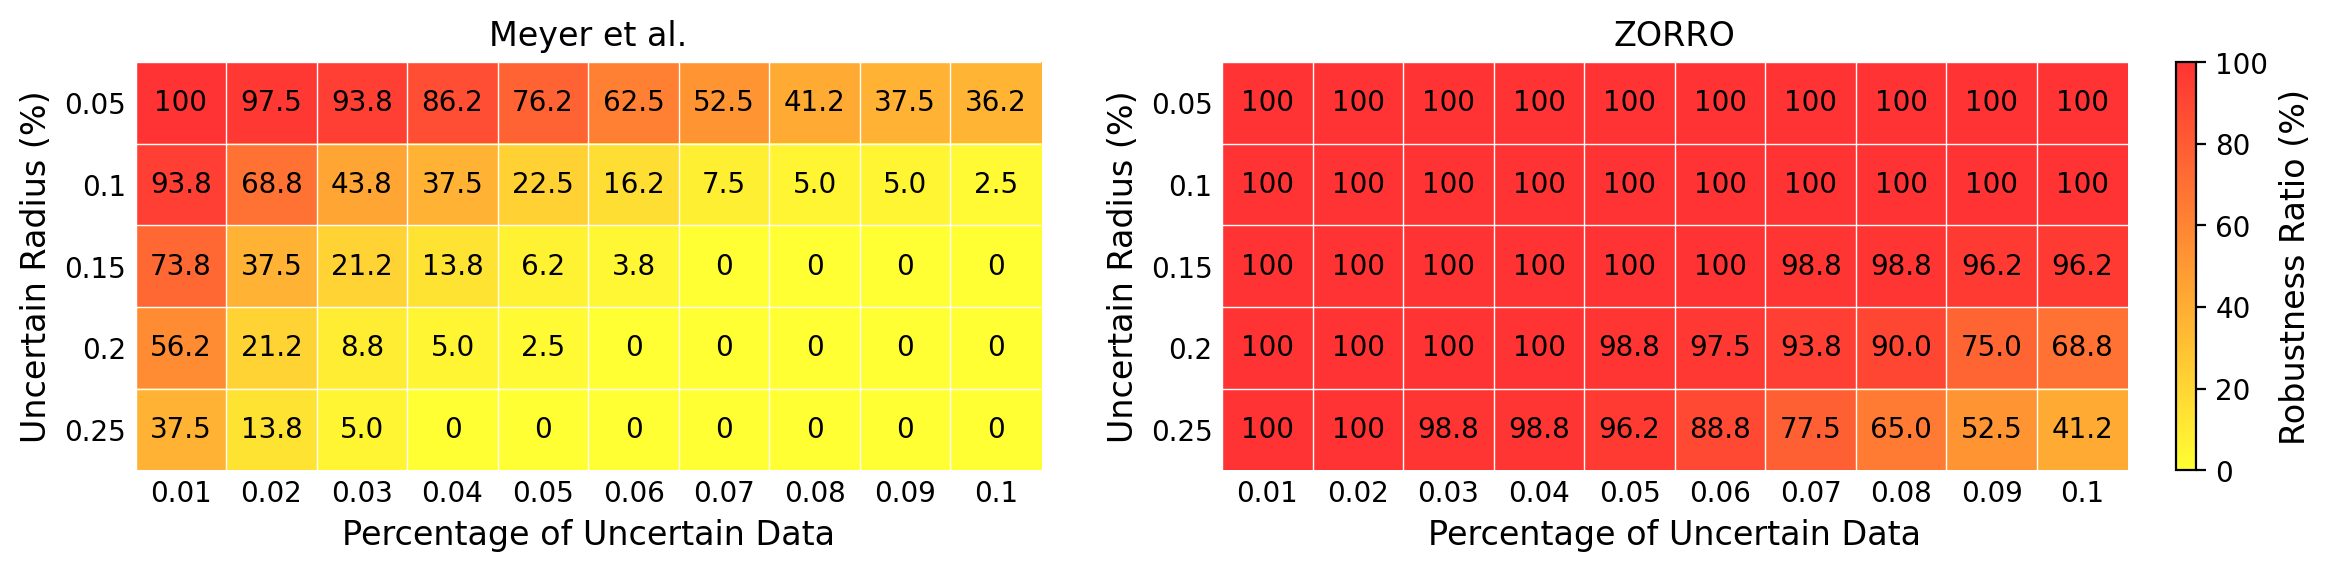

In [87]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('mpg-ridge-r2-sensitive-heatmap.pdf', bbox_inches='tight')

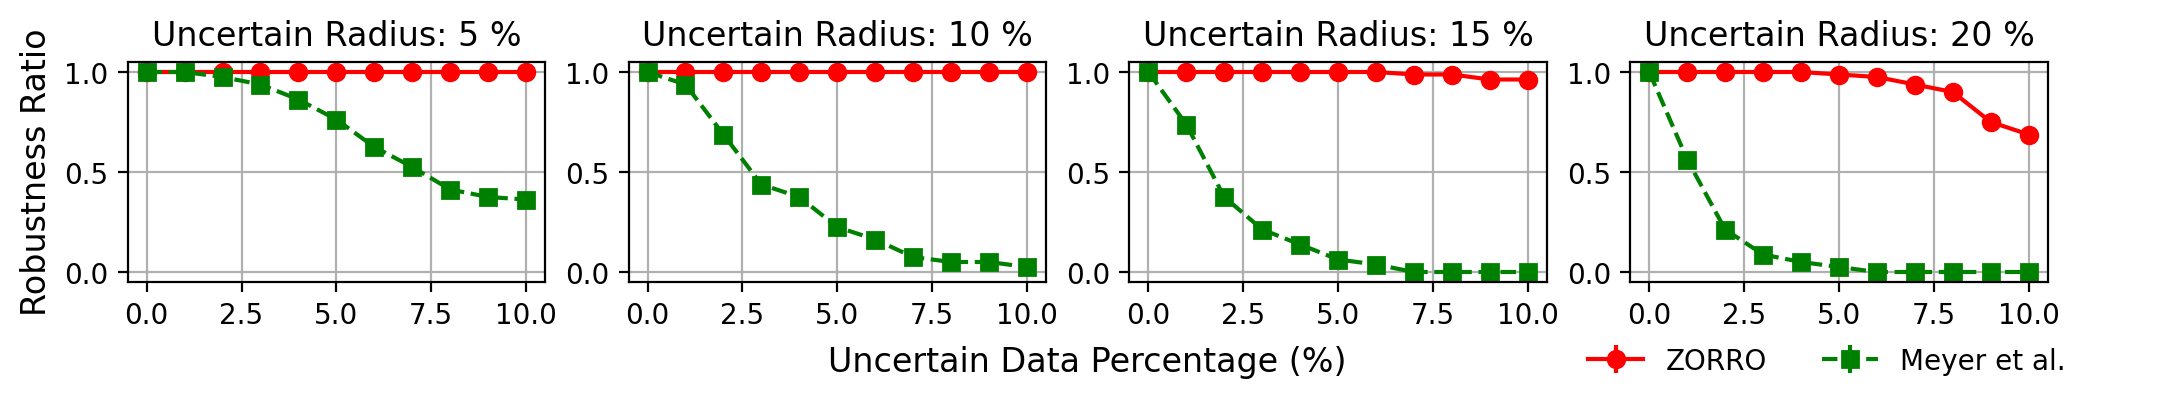

In [88]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-ridge-r2-sensitive-labels-lineplot.pdf', bbox_inches='tight')